In [33]:
#!pip install geopy

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
from pathlib import Path
import pandas as pd
import numpy as np
#from geopy.geocoders import Nominatim
import datetime
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.under_sampling import RandomUnderSampler

from imblearn.over_sampling import SMOTE
import pickle

In [36]:
# Define the path to the folder
# folder_path = Path("C:/Users/crazy/OneDrive - The City College of New York/DSE I2100 - Applied Machine Learning and Data Mining/Project")
# csv_file = folder_path.glob("*.csv").__next__()

# Load CSV file into DataFrame
# df = pd.read_csv(csv_file)


# df = pd.read_csv('/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Crashes.csv', nrows=400000)

df = pd.read_csv('/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Crashes.csv')


<ipython-input-36-4dca41c7a111>:11: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Crashes.csv')


## Data Preprocessing

In [37]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077598 entries, 0 to 2077597
Data columns (total 29 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   CRASH DATE                     2077598 non-null  object 
 1   CRASH TIME                     2077598 non-null  object 
 2   BOROUGH                        1431167 non-null  object 
 3   ZIP CODE                       1430917 non-null  object 
 4   LATITUDE                       1843830 non-null  float64
 5   LONGITUDE                      1843830 non-null  float64
 6   LOCATION                       1843830 non-null  object 
 7   ON STREET NAME                 1636440 non-null  object 
 8   CROSS STREET NAME              1292051 non-null  object 
 9   OFF STREET NAME                348785 non-null   object 
 10  NUMBER OF PERSONS INJURED      2077580 non-null  float64
 11  NUMBER OF PERSONS KILLED       2077567 non-null  float64
 12  NUMBER OF PEDE

In [38]:
df.isnull().sum()

CRASH DATE                             0
CRASH TIME                             0
BOROUGH                           646431
ZIP CODE                          646681
LATITUDE                          233768
LONGITUDE                         233768
LOCATION                          233768
ON STREET NAME                    441158
CROSS STREET NAME                 785547
OFF STREET NAME                  1728813
NUMBER OF PERSONS INJURED             18
NUMBER OF PERSONS KILLED              31
NUMBER OF PEDESTRIANS INJURED          0
NUMBER OF PEDESTRIANS KILLED           0
NUMBER OF CYCLIST INJURED              0
NUMBER OF CYCLIST KILLED               0
NUMBER OF MOTORIST INJURED             0
NUMBER OF MOTORIST KILLED              0
CONTRIBUTING FACTOR VEHICLE 1       6814
CONTRIBUTING FACTOR VEHICLE 2     322220
CONTRIBUTING FACTOR VEHICLE 3    1929123
CONTRIBUTING FACTOR VEHICLE 4    2044064
CONTRIBUTING FACTOR VEHICLE 5    2068510
COLLISION_ID                           0
VEHICLE TYPE COD

### Correcting values in # of persons injured/killed:

In [39]:
#Sum the injury-related columns
injury_columns = ['NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF MOTORIST INJURED']
df['NUMBER OF PERSONS INJURED'] = df[injury_columns].sum(axis=1)

#Sum the killed-related columns
killed_columns = ['NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST KILLED']
df['NUMBER OF PERSONS KILLED'] = df[killed_columns].sum(axis=1)

In [40]:
df[['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']].sample(10)

,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED
1545974,0,0
108545,0,0
688124,0,0
1716154,0,0
1008019,0,0
1358730,0,0
535660,0,0
2049803,0,0
165719,0,0
436096,0,0


### The Following code replaces row value coordinates not in NYC with NaN for 'LATITUDE' & 'LONGITUDE' columns:

In [41]:
# Approximate coordinates for New York City:
# Maximum Latitude: 40.9176 (Northernmost point of the Bronx)
# Minimum Latitude: 40.4774 (Southernmost point of Staten Island)
# Maximum Longitude: -73.7004 (Easternmost point of Queens)
# Minimum Longitude: -74.2591 (Westernmost point of Staten Island)

# Define the maximum and minimum values for latitude and longitude
max_latitude = 40.9176
min_latitude = 40.4774
max_longitude = -73.7004
min_longitude = -74.2591

# Filter the DataFrame based on the conditions for latitude and longitude
invalid_latitudes = (df['LATITUDE'] > max_latitude) | (df['LATITUDE'] < min_latitude)
invalid_longitudes = (df['LONGITUDE'] > max_longitude) | (df['LONGITUDE'] < min_longitude)

# Replace the values with NaN where the conditions are not met
df.loc[invalid_latitudes, 'LATITUDE'] = np.nan
df.loc[invalid_longitudes, 'LONGITUDE'] = np.nan

In [42]:
print(df['NUMBER OF PERSONS INJURED'].value_counts())

NUMBER OF PERSONS INJURED
0     1609447
1      362338
2       68962
3       22648
4        8407
5        3231
6        1352
7         574
8         252
9         129
10         85
11         50
12         32
13         27
15         14
14         10
16          8
17          6
18          6
22          3
19          3
24          3
20          2
43          1
34          1
23          1
21          1
31          1
32          1
27          1
40          1
25          1
Name: count, dtype: int64


In [43]:
print(df['NUMBER OF PERSONS KILLED'].value_counts())

NUMBER OF PERSONS KILLED
0    2074662
1       2844
2         74
3         12
4          3
5          2
8          1
Name: count, dtype: int64


### Creating target column "CLASS TYPE":

In [44]:
def determine_class_type(row):
    if row['NUMBER OF PERSONS INJURED'] == 0 and row['NUMBER OF PERSONS KILLED'] == 0:
        return '0'
    else:
        return '1'

df['CLASS TYPE'] = df.apply(determine_class_type, axis=1)
df['CLASS TYPE'] = df['CLASS TYPE'].astype('int64')

### Dropping redundant/unnecessary columns:

In [45]:
df.drop(columns = ['BOROUGH', 'ZIP CODE', 'LOCATION', 'ON STREET NAME','CROSS STREET NAME','OFF STREET NAME',
                   'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
                   'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
                   'NUMBER OF MOTORIST INJURED','NUMBER OF MOTORIST KILLED', 'COLLISION_ID'], axis=1, inplace=True)

In [46]:
df.sample(30)

,CRASH DATE,CRASH TIME,LATITUDE,LONGITUDE,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,CLASS TYPE
2075016,03/21/2024,14:00,40.685883,-73.880190,Passing Too Closely,Unspecified,NaN,NaN,NaN,Station Wagon/Sport Utility Vehicle,Box Truck,NaN,NaN,NaN,0
1401807,01/24/2015,10:30,NaN,NaN,Backing Unsafely,NaN,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,0
218395,09/04/2020,18:05,40.584698,-73.984010,Unspecified,Unspecified,NaN,NaN,NaN,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,0
510835,12/29/2018,1:20,40.656340,-73.921370,Alcohol Involvement,Unspecified,NaN,NaN,NaN,Sedan,Sedan,NaN,NaN,NaN,0
1812923,01/21/2013,16:42,40.704403,-73.814439,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,0
87787,11/08/2021,19:45,40.719370,-73.787600,Passing or Lane Usage Improper,Unspecified,Unspecified,NaN,NaN,Sedan,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,0
1290534,08/07/2015,17:19,40.842993,-73.826240,Other Vehicular,Other Vehicular,NaN,NaN,NaN,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,0
170854,01/19/2021,7:59,40.765724,-73.959000,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,Station Wagon/Sport Utility Vehicle,Bike,NaN,NaN,NaN,1
2066611,02/09/2024,18:55,40.819542,-73.913530,Traffic Control Disregarded,NaN,NaN,NaN,NaN,E-Bike,NaN,NaN,NaN,NaN,1
1396217,02/16/2015,21:15,40.690695,-73.957273,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,VAN,PASSENGER VEHICLE,NaN,NaN,NaN,0


In [47]:
df['VEHICLE TYPE CODE 1'] = df['VEHICLE TYPE CODE 1'].str.title()
df['VEHICLE TYPE CODE 2'] = df['VEHICLE TYPE CODE 2'].str.title()
df['VEHICLE TYPE CODE 3'] = df['VEHICLE TYPE CODE 3'].str.title()
df['VEHICLE TYPE CODE 4'] = df['VEHICLE TYPE CODE 4'].str.title()
df['VEHICLE TYPE CODE 5'] = df['VEHICLE TYPE CODE 5'].str.title()

### Removing/Replacing NaN values for Contributing Factor & Vehicle Type columns:

In [48]:
# Drop NaN values from subset columns
df = df.dropna(subset=['CONTRIBUTING FACTOR VEHICLE 1', 'VEHICLE TYPE CODE 1'])

# List of column pairs
column_pairs = [
    ('CONTRIBUTING FACTOR VEHICLE 2', 'VEHICLE TYPE CODE 2'),
    ('CONTRIBUTING FACTOR VEHICLE 3', 'VEHICLE TYPE CODE 3'),
    ('CONTRIBUTING FACTOR VEHICLE 4', 'VEHICLE TYPE CODE 4'),
    ('CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 5')
]

# Iterate over each column pair
for factor_column, type_column in column_pairs:
    # Check if factor_column has a value and type_column is NaN
    mask = (pd.notna(df[factor_column])) & (pd.isna(df[type_column]))
    # Check if type_column has a value and factor_column is NaN
    mask |= (pd.notna(df[type_column])) & (pd.isna(df[factor_column]))
    # Drop rows where either condition is met
    df = df[~mask]

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

# Fill NaN values in contributing factor vehicle columns with 'No vehicle'
for factor_column, type_column in column_pairs:
    df[factor_column].fillna('None', inplace=True)
    df[type_column].fillna('None', inplace=True)

In [49]:
df.isnull().sum()

CRASH DATE                            0
CRASH TIME                            0
LATITUDE                         225626
LONGITUDE                        225744
CONTRIBUTING FACTOR VEHICLE 1         0
CONTRIBUTING FACTOR VEHICLE 2         0
CONTRIBUTING FACTOR VEHICLE 3         0
CONTRIBUTING FACTOR VEHICLE 4         0
CONTRIBUTING FACTOR VEHICLE 5         0
VEHICLE TYPE CODE 1                   0
VEHICLE TYPE CODE 2                   0
VEHICLE TYPE CODE 3                   0
VEHICLE TYPE CODE 4                   0
VEHICLE TYPE CODE 5                   0
CLASS TYPE                            0
dtype: int64

### Dropping rows with NaN values:

In [50]:
df = df.dropna()

### Verifying column dtype:

In [51]:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'], format='%H:%M')


df['YEAR'] = df['CRASH DATE'].dt.year
df['MONTH'] = df['CRASH DATE'].dt.month
df['DAY'] = df['CRASH DATE'].dt.day

df['HOUR'] = df['CRASH TIME'].dt.hour
df['MINUTE'] = df['CRASH TIME'].dt.minute

df['DAY OF WEEK'] = df['CRASH DATE'].dt.dayofweek

In [52]:
df.drop(['CRASH DATE', 'CRASH TIME'], axis=1, inplace=True)

In [53]:
df.isnull().sum()

LATITUDE                         0
LONGITUDE                        0
CONTRIBUTING FACTOR VEHICLE 1    0
CONTRIBUTING FACTOR VEHICLE 2    0
CONTRIBUTING FACTOR VEHICLE 3    0
CONTRIBUTING FACTOR VEHICLE 4    0
CONTRIBUTING FACTOR VEHICLE 5    0
VEHICLE TYPE CODE 1              0
VEHICLE TYPE CODE 2              0
VEHICLE TYPE CODE 3              0
VEHICLE TYPE CODE 4              0
VEHICLE TYPE CODE 5              0
CLASS TYPE                       0
YEAR                             0
MONTH                            0
DAY                              0
HOUR                             0
MINUTE                           0
DAY OF WEEK                      0
dtype: int64

In [54]:
df['LATITUDE'] = df['LATITUDE'].astype('float64')
df['LONGITUDE'] = df['LONGITUDE'].astype('float64')
df['CONTRIBUTING FACTOR VEHICLE 1'] = df['CONTRIBUTING FACTOR VEHICLE 1'].astype('object')
df['CONTRIBUTING FACTOR VEHICLE 2'] = df['CONTRIBUTING FACTOR VEHICLE 2'].astype('object')
df['CONTRIBUTING FACTOR VEHICLE 3'] = df['CONTRIBUTING FACTOR VEHICLE 3'].astype('object')
df['CONTRIBUTING FACTOR VEHICLE 4'] = df['CONTRIBUTING FACTOR VEHICLE 4'].astype('object')
df['CONTRIBUTING FACTOR VEHICLE 5'] = df['CONTRIBUTING FACTOR VEHICLE 5'].astype('object')
df['VEHICLE TYPE CODE 1'] = df['VEHICLE TYPE CODE 1'].astype('object')
df['VEHICLE TYPE CODE 2'] = df['VEHICLE TYPE CODE 2'].astype('object')
df['VEHICLE TYPE CODE 3'] = df['VEHICLE TYPE CODE 3'].astype('object')
df['VEHICLE TYPE CODE 4'] = df['VEHICLE TYPE CODE 4'].astype('object')
df['VEHICLE TYPE CODE 5'] = df['VEHICLE TYPE CODE 5'].astype('object')

In [55]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1701713 entries, 3 to 1927466
Data columns (total 19 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   LATITUDE                       1701713 non-null  float64
 1   LONGITUDE                      1701713 non-null  float64
 2   CONTRIBUTING FACTOR VEHICLE 1  1701713 non-null  object 
 3   CONTRIBUTING FACTOR VEHICLE 2  1701713 non-null  object 
 4   CONTRIBUTING FACTOR VEHICLE 3  1701713 non-null  object 
 5   CONTRIBUTING FACTOR VEHICLE 4  1701713 non-null  object 
 6   CONTRIBUTING FACTOR VEHICLE 5  1701713 non-null  object 
 7   VEHICLE TYPE CODE 1            1701713 non-null  object 
 8   VEHICLE TYPE CODE 2            1701713 non-null  object 
 9   VEHICLE TYPE CODE 3            1701713 non-null  object 
 10  VEHICLE TYPE CODE 4            1701713 non-null  object 
 11  VEHICLE TYPE CODE 5            1701713 non-null  object 
 12  CLASS TYPE         

In [56]:
# Dictionary to map the repeated values to the unified values
replace_dict = {
    'sport utility / station wagon': 'Station Wagon/uv',
    'station wagon/sport utility vehicle': 'station wagon/suv',
    '4 dr sedan': 'Sedan',
    '2 dr sedan': 'Sedan',
}

# Replace the values in the specified columns
columns_to_replace = ['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']
df[columns_to_replace] = df[columns_to_replace].replace(replace_dict)

### Keeping only top 10 values in Contributing Factor & Vehicle Type columns:

In [57]:
# List of columns to iterate through
columns_to_iterate = [
    'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
    'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3','VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'
]

# Iterate over each column
for column in columns_to_iterate:
    # Get the top 10 most frequent values in the column
    top_10_values = df[column].value_counts().head(10).index.tolist()
    # Replace values not in top 10 with a placeholder value
    df[column] = df[column].apply(lambda x: x if x in top_10_values else 'Other')

    # Drop rows where any of the specified columns have 'Other' value
    df = df[df[column] != 'Other']

    # Reset the index after dropping rows
    df.reset_index(drop=True, inplace=True)


In [58]:
df.sample(35)

,LATITUDE,LONGITUDE,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,CLASS TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,DAY OF WEEK
306581,40.794650,-73.971794,Following Too Closely,Following Too Closely,None,None,None,Sedan,Sedan,None,None,None,0,2018,9,26,14,50,2
217861,40.805557,-73.910470,Passing or Lane Usage Improper,Unspecified,None,None,None,Station Wagon/Sport Utility Vehicle,Sedan,None,None,None,0,2019,5,25,17,5,5
618818,40.827583,-73.949610,Unspecified,None,None,None,None,4 Dr Sedan,None,None,None,None,0,2016,6,22,18,30,2
541369,40.694794,-73.982460,Passing or Lane Usage Improper,Passing or Lane Usage Improper,None,None,None,Sedan,Station Wagon/Sport Utility Vehicle,None,None,None,0,2017,1,20,12,20,4
765632,40.835530,-73.863156,Driver Inattention/Distraction,Unspecified,None,None,None,Passenger Vehicle,Sport Utility / Station Wagon,None,None,None,0,2015,1,9,20,50,4
921558,40.756672,-73.828793,Unspecified,Unspecified,None,None,None,Passenger Vehicle,Passenger Vehicle,None,None,None,0,2013,7,23,9,15,1
837522,40.720820,-73.806363,Backing Unsafely,Unspecified,None,None,None,Passenger Vehicle,Passenger Vehicle,None,None,None,0,2014,5,19,16,50,0
832230,40.607133,-73.939726,Unspecified,Unspecified,None,None,None,Passenger Vehicle,Unknown,None,None,None,0,2014,5,18,1,0,6
17364,40.666380,-73.861090,Unspecified,None,None,None,None,Station Wagon/Sport Utility Vehicle,None,None,None,None,0,2022,4,5,7,56,1
939518,40.728447,-73.981791,Unspecified,Unspecified,None,None,None,Passenger Vehicle,Unknown,None,None,None,0,2013,5,31,9,50,4


### Converting new dataframe to csv file:

In [59]:
# Save the DataFrame to a CSV file
df.to_csv('Processed_Data_v2.csv', index=False)

## Exploratory Data Analysis

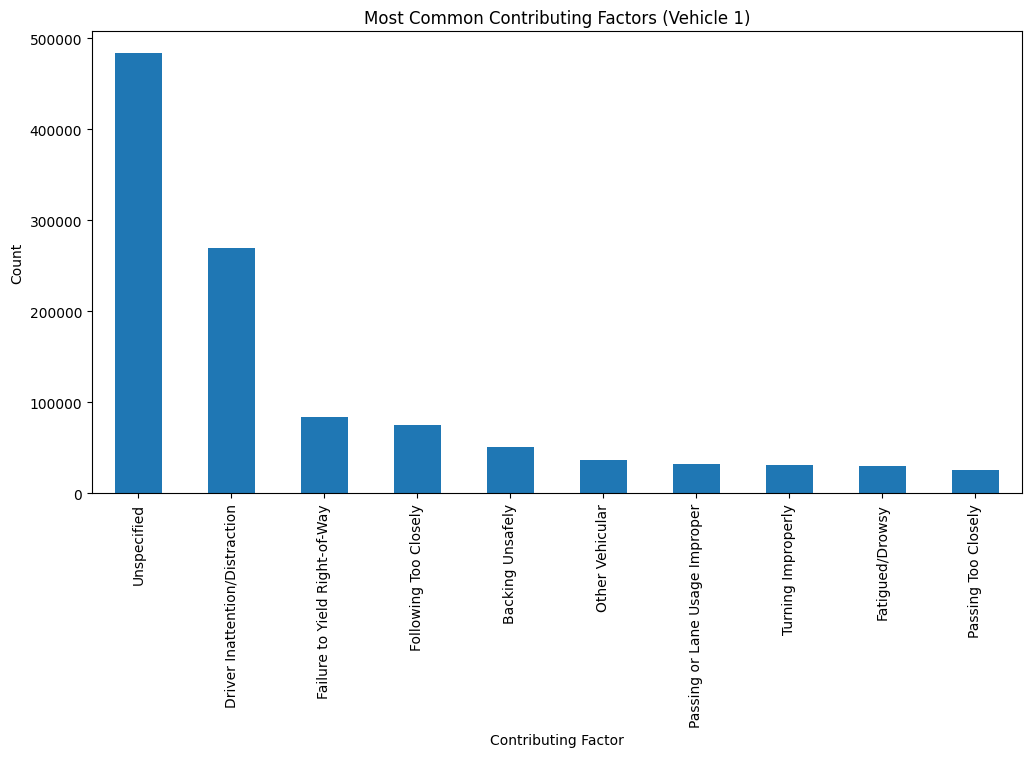

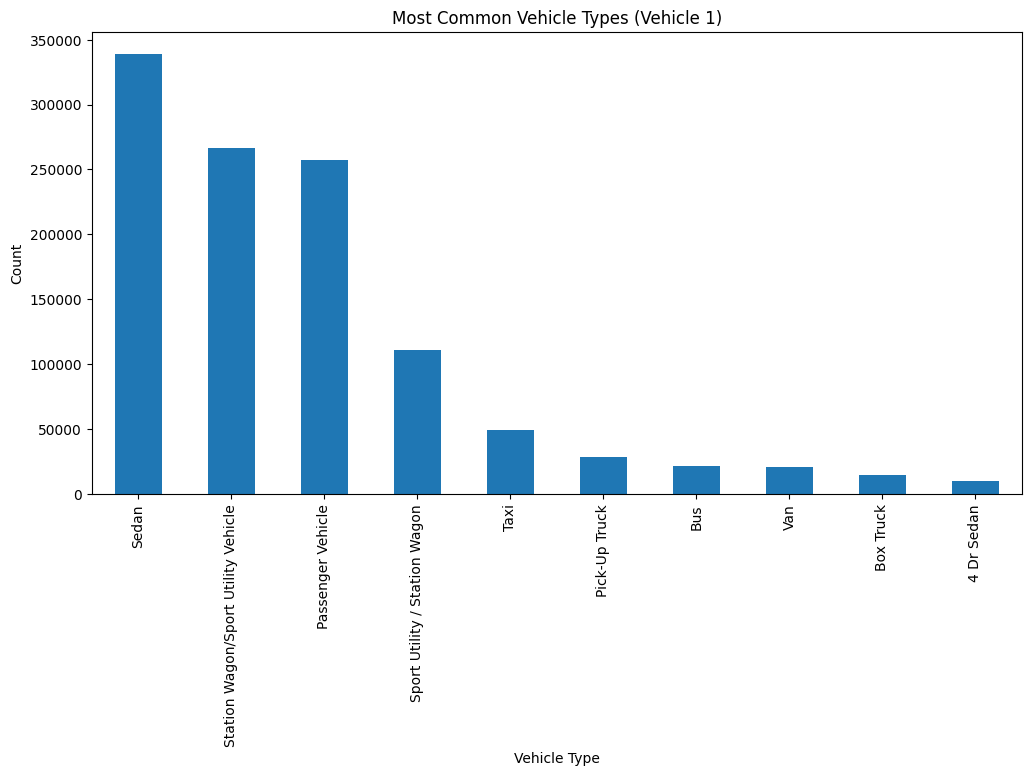

In [60]:

import matplotlib.pyplot as plt

# Create a bar chart for Contributing Factor Vehicle 1
plt.figure(figsize=(12, 6))
df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().plot(kind='bar')
plt.title('Most Common Contributing Factors (Vehicle 1)')
plt.xlabel('Contributing Factor')
plt.ylabel('Count')
plt.show()

# Create a bar chart for Vehicle Type Code 1
plt.figure(figsize=(12, 6))
df['VEHICLE TYPE CODE 1'].value_counts().plot(kind='bar')
plt.title('Most Common Vehicle Types (Vehicle 1)')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.show()


## Model Building

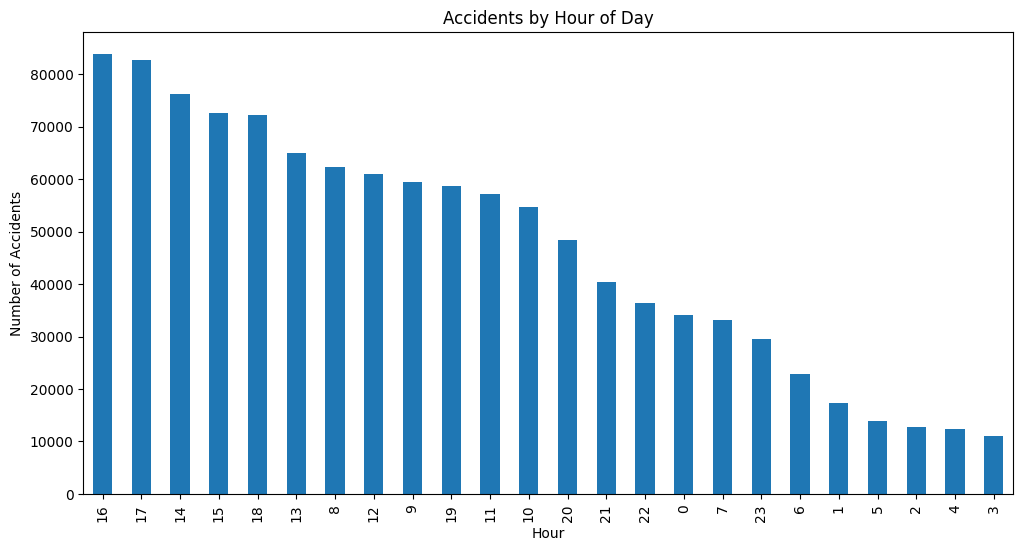

In [61]:
plt.figure(figsize=(12, 6))
df['HOUR'].value_counts().plot(kind='bar')
plt.title('Accidents by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Accidents')
plt.show()


In [62]:
print(df.isnull().sum())

LATITUDE                         0
LONGITUDE                        0
CONTRIBUTING FACTOR VEHICLE 1    0
CONTRIBUTING FACTOR VEHICLE 2    0
CONTRIBUTING FACTOR VEHICLE 3    0
CONTRIBUTING FACTOR VEHICLE 4    0
CONTRIBUTING FACTOR VEHICLE 5    0
VEHICLE TYPE CODE 1              0
VEHICLE TYPE CODE 2              0
VEHICLE TYPE CODE 3              0
VEHICLE TYPE CODE 4              0
VEHICLE TYPE CODE 5              0
CLASS TYPE                       0
YEAR                             0
MONTH                            0
DAY                              0
HOUR                             0
MINUTE                           0
DAY OF WEEK                      0
dtype: int64


In [63]:
df.sample(20)

,LATITUDE,LONGITUDE,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,CLASS TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,DAY OF WEEK
913990,40.746493,-74.001324,Unspecified,Unspecified,None,None,None,Passenger Vehicle,Passenger Vehicle,None,None,None,1,2013,8,15,10,25,3
245354,40.752598,-73.967020,Passing or Lane Usage Improper,Unspecified,None,None,None,Taxi,Bus,None,None,None,0,2019,3,11,12,12,0
578822,40.581512,-73.959915,Driver Inattention/Distraction,Unspecified,None,None,None,Sedan,Sedan,None,None,None,0,2016,10,10,15,40,0
885973,40.654840,-73.959696,Unspecified,Unspecified,None,None,None,Sport Utility / Station Wagon,Van,None,None,None,0,2013,11,10,21,10,6
1112988,40.803480,-73.948640,Driver Inattention/Distraction,Unspecified,None,None,None,Pick-Up Truck,Sedan,None,None,None,0,2024,2,22,13,53,3
119883,40.645546,-73.905660,Unspecified,None,None,None,None,Sedan,None,None,None,None,0,2020,2,22,20,0,5
910397,40.734874,-73.882108,Unspecified,Unspecified,None,None,None,Sport Utility / Station Wagon,Passenger Vehicle,None,None,None,0,2013,10,1,16,30,1
636597,40.650715,-73.951378,Unspecified,None,None,None,None,Passenger Vehicle,None,None,None,None,1,2016,3,5,20,33,5
987658,40.710027,-73.834053,Unspecified,Unspecified,None,None,None,Passenger Vehicle,Passenger Vehicle,None,None,None,0,2013,1,13,12,21,6
554944,40.669586,-73.928270,Unspecified,Unspecified,Unspecified,None,None,Sedan,Sedan,Sedan,None,None,0,2016,12,13,15,0,1


In [64]:
df['CLASS TYPE'].value_counts()

CLASS TYPE
0    887647
1    229852
Name: count, dtype: int64

In [65]:
df.columns

Index(['LATITUDE', 'LONGITUDE', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3',
       'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5', 'CLASS TYPE', 'YEAR',
       'MONTH', 'DAY', 'HOUR', 'MINUTE', 'DAY OF WEEK'],
      dtype='object')

In [66]:
df = pd.get_dummies(df)
df.sample(10)


,LATITUDE,LONGITUDE,CLASS TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,DAY OF WEEK,CONTRIBUTING FACTOR VEHICLE 1_Backing Unsafely,...,VEHICLE TYPE CODE 4_Van,VEHICLE TYPE CODE 5_None,VEHICLE TYPE CODE 5_Passenger Vehicle,VEHICLE TYPE CODE 5_Pick-Up Truck,VEHICLE TYPE CODE 5_Sedan,VEHICLE TYPE CODE 5_Sport Utility / Station Wagon,VEHICLE TYPE CODE 5_Station Wagon/Sport Utility Vehicle,VEHICLE TYPE CODE 5_Taxi,VEHICLE TYPE CODE 5_Unknown,VEHICLE TYPE CODE 5_Van
1098495,40.571040,-74.109190,0,2023,6,13,18,10,1,False,...,False,True,False,False,False,False,False,False,False,False
1044704,40.858775,-73.910885,0,2012,7,23,9,10,0,False,...,False,True,False,False,False,False,False,False,False,False
95599,40.778614,-73.839770,1,2020,9,2,20,15,2,False,...,False,True,False,False,False,False,False,False,False,False
842584,40.662967,-73.906137,0,2014,4,27,15,20,6,False,...,False,True,False,False,False,False,False,False,False,False
935340,40.622265,-73.965717,0,2013,6,26,15,0,2,False,...,False,True,False,False,False,False,False,False,False,False
167154,40.547160,-74.216860,0,2019,10,27,9,15,6,False,...,False,True,False,False,False,False,False,False,False,False
192678,40.753643,-73.907670,0,2019,8,14,11,10,2,False,...,False,True,False,False,False,False,False,False,False,False
684443,40.665496,-73.755720,0,2015,9,21,8,30,0,False,...,False,True,False,False,False,False,False,False,False,False
629032,40.685436,-73.793260,0,2016,3,18,10,30,4,False,...,False,True,False,False,False,False,False,False,False,False
601284,40.718987,-73.946350,0,2016,8,6,0,0,5,False,...,False,True,False,False,False,False,False,False,False,False


In [67]:
df.columns

Index(['LATITUDE', 'LONGITUDE', 'CLASS TYPE', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'MINUTE', 'DAY OF WEEK',
       'CONTRIBUTING FACTOR VEHICLE 1_Backing Unsafely',
       ...
       'VEHICLE TYPE CODE 4_Van', 'VEHICLE TYPE CODE 5_None',
       'VEHICLE TYPE CODE 5_Passenger Vehicle',
       'VEHICLE TYPE CODE 5_Pick-Up Truck', 'VEHICLE TYPE CODE 5_Sedan',
       'VEHICLE TYPE CODE 5_Sport Utility / Station Wagon',
       'VEHICLE TYPE CODE 5_Station Wagon/Sport Utility Vehicle',
       'VEHICLE TYPE CODE 5_Taxi', 'VEHICLE TYPE CODE 5_Unknown',
       'VEHICLE TYPE CODE 5_Van'],
      dtype='object', length=108)

In [72]:
X = df.drop('CLASS TYPE', axis=1)
y = df['CLASS TYPE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [92]:
rfu_model = make_pipeline_imb(
    RandomUnderSampler(random_state=1234),
    RandomForestClassifier(random_state=1234)
)
rfu_model.fit(X_train, y_train)
y_pred = rfu_model.predict(X_test)

In [93]:
rfu_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {rfu_accuracy}')

print(classification_report(y_test, y_pred))

Accuracy: 0.725910514541387
              precision    recall  f1-score   support

           0       0.89      0.75      0.81    177459
           1       0.40      0.64      0.49     46041

    accuracy                           0.73    223500
   macro avg       0.64      0.69      0.65    223500
weighted avg       0.79      0.73      0.75    223500



In [94]:
with open('rfu_model_two_classes.pkl', 'wb') as f:
    pickle.dump(y_pred, f)